<center>
<h1> Convex Optimization </h1>
<h2> Homework 3 : LASSO </h2>
Student : Simon Queric 
</center>

In order to run this notebook, please use a Python environment with the following packages : 
- cvxpy 
- numpy
- matplotlib

### Question 1

The lagrangian of the LASSO problem, with change of variable $u = Xw - y$ and dual variable $v$, is 

$$ L(w, u, v) = \frac{1}{2}\|u\|^2_2 + \lambda\|w\|_1 + v^T(Xw - y - u)$$

Maximizing the lagrangian over $w, u$ gives us the dual function $\displaystyle g(v) = -\frac{v^Tv}{2} - y^Tv - I \left(\frac{X^Tv}{\lambda}\right)$
where $I(x) = 0 \text{ if } \|x\|_{\infty} \leq 1 \text{ and } +\infty \text{ otherwise} $.


Hence, the dual of LASSO is :

$$ \max_v -\frac{v^Tv}{2} - y^Tv $$

such that 

$$ \|X^Tv\|_{\infty} \leqslant \lambda  $$

$\Longleftrightarrow$

$$ \begin{pmatrix} X^T \\ -X^T \end{pmatrix} v \leqslant \lambda $$

It's exactly a quadratic problem with :

\begin{align*}
    Q &= \frac{1}{2}I_n \\
    p &= y \\
    A &= \binom{X^T}{-X^T} \\
    b &= (\lambda, \cdots, \lambda)^T
\end{align*}


#### Derivations of gradient and hessian of for the log-barrier objective function

We consider the approximation of the quadratic program via logarithmic barrier. 
The objective function is : $$f(v) = t(v^TQv + p^Tv) - \sum_{i=1}^{m}{\log{(b_i - a_i^Tv)}}$$

The gradient of $f$ is equal to $$\nabla f(v) = 2tQv + tp + \sum_{i=1}^m{\frac{a_i}{(b_i - a_i^Tv)}} $$

The hessian of $f$ is $$\nabla^2f(v) = 2tQ + \sum_{i=1}^m{\frac{a_ia_i^T}{(b_i - a_i^Tv)^2}}$$

### Question 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

In [3]:
def f0(Q, p, v) :
    """Compute the quadratic form vTQv + pTv"""

    vQv = np.einsum("i, ij, j", v, Q, v)
    pv = np.einsum("i,i ->", p, v)
    return vQv + pv 

def f(Q, p, A, b, v, t) :
    """Compute the quadratic form with a log-barrier penalty"""
    Av = np.einsum("ij, j -> i", A, v)
    vQv = np.einsum("i, ij, j", v, Q, v)
    pv = np.einsum("i,i ->", p, v)
    z = (b-Av)
    return t*vQv + t*pv - np.sum(np.log(z))

def H(Q, p, A, b, v, t) :
    """Compute the Hessian of f"""
    Av = np.einsum("ij, j -> i", A, v)
    m, _ = np.shape(A)
    z = 1 / (Av-b)**2
    s = np.einsum("ij, ik, i -> jk", A, A, z)
    return 2*t*Q + s

def grad(Q, p, A, b, v, t) :
    """Compute the gradient of f"""
    Qv = np.einsum("ij, j -> i", Q, v) # Q@v
    Av = np.einsum("ij, j -> i", A, v) # A@v
    z = 1 / (b-Av)
    return 2*t*Qv + t*p + np.einsum("ki, k -> i", A, z)

def centering_step(Q, p, A, b, t, v0, eps) :
    """Centering step of the log-barrier method for a quadratic program"""
    V = [v0]
    v = np.copy(v0)
    alpha = 0.1
    beta = 0.7
    u = 1
    
    # Newton's method
    Hessian = H(Q, p, A, b, v, t)
    g = grad(Q, p, A, b, v, t)
    Hinv = np.linalg.inv(Hessian)
    delta_v = -Hinv@g
    decrement = -g@delta_v
    
    while decrement**2/2 > eps : 
        
        fv = f(Q, p, A, b, v, t)
        u = 1

        # Backtracking line search
        while f(Q, p, A, b, v + u*delta_v, t) >= fv - alpha*u*decrement :
            u*= beta

        # Update
        v+=u*delta_v 
        Hessian = H(Q, p, A, b, v, t) 
        g = grad(Q, p, A, b, v, t)
        Hinv = np.linalg.inv(Hessian) 
        delta_v = -Hinv@g 
        decrement = -g@delta_v
        V.append(v)
    
    return V 

def barr_method(Q, p, A, b, v0, eps, mu=10) :
    """Implement the log-barrier method for a quadratic program"""
    V = [v0]
    m, _ = np.shape(A)
    t = 1
    vt = np.copy(v0)
    k=0
    while m/t > eps : 
        vt = centering_step(Q, p, A, b, t, vt, eps)
        V+=vt
        t *= mu
        vt = vt[-1]
 
    return V

In [14]:
# Parameters and data
#np.random.seed(42)
Lambda = 10
d = 500
n = 15
y = np.random.uniform(size=n) #/ 4
X = np.random.uniform(size=(n, d)) # / 4

Q = np.eye(n)/2
p = y
A = np.zeros((2*d, n))
A[:d,:]= X.T
A[d:,:] = -X.T
b = Lambda*np.ones(2*d)
v = np.random.normal(size=n)

In [15]:
grad(Q, p, A, b, v, t=1)

array([20.43880374, 23.36460682, 19.72383871, 18.04394286, 22.46283482,
       20.92224608, 18.82933133, 18.75939244, 18.92399587, 18.94185653,
       18.12638677, 15.8534137 , 18.60905017, 22.98243353, 17.57115111])

57
Value of the optimum for mu = 2.5 : -2.5996
23
Value of the optimum for mu = 15 : -2.5996
20
Value of the optimum for mu = 20 : -2.5996
17
Value of the optimum for mu = 50 : -2.5996
15
Value of the optimum for mu = 100 : -2.5996


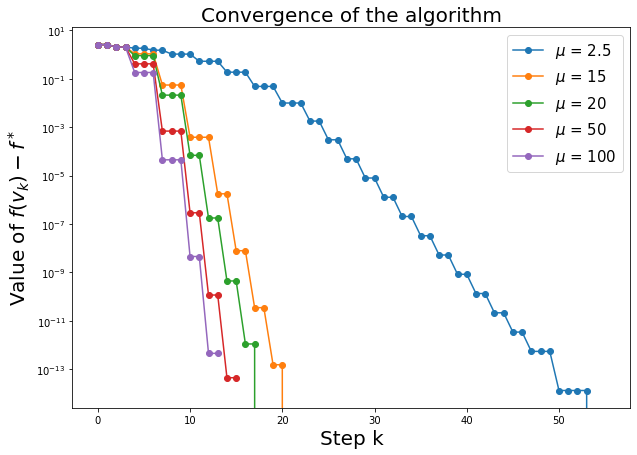

In [21]:
fig = plt.figure(figsize=(10, 7))

for mu in [2.5, 15, 20, 50, 100] :
    V = barr_method(Q, p, A, b, v0=np.zeros(n), eps=1e-8, mu=mu) 
    x = []
    for v in V : 
        x.append(f0(Q, p, v))
    print(len(V))
    print("Value of the optimum for mu = {} : {:.4f}".format(mu, f0(Q, p, V[-1])))
    plt.plot(np.array(x)[:-1]-x[-1], marker='o')
    plt.yscale("log")
    plt.xlabel("Step k", fontsize=20)
    plt.ylabel("Value of $f(v_k) - f^*$", fontsize=20)
    plt.title("Convergence of the algorithm", fontsize=20)

plt.legend(["$\mu$ = {}".format(mu) for mu in [2.5, 15, 20, 50, 100]], fontsize=15)
plt.show()

Let's check if our implementation of Newton's method is correct, using `cvxpy` library. 

In [17]:
v = cp.Variable(n)
prob = cp.Problem(cp.Minimize(cp.quad_form(v, Q) + p.T @ v),
                 [A @ v <= b])
print("Value of the optimum : {:.4f}".format(prob.solve()))
print("Optimal point :", v.value)
print("Optimal point obtained with a log-barrier method :", V[-1])

Value of the optimum : -2.5996
Optimal point : [-2.32133913e-01 -9.43042527e-04 -7.57150580e-01 -9.85207326e-01
 -8.09913120e-01 -4.60206618e-01 -9.03767261e-01 -4.09847673e-01
 -5.24934084e-01 -4.77129767e-01 -4.47623873e-01 -7.75190769e-01
 -5.26768907e-01 -3.16717122e-01 -2.58158168e-01]
Optimal point obtained with a log-barrier method : [-2.32133910e-01 -9.43040075e-04 -7.57150578e-01 -9.85207323e-01
 -8.09913118e-01 -4.60206616e-01 -9.03767259e-01 -4.09847671e-01
 -5.24934082e-01 -4.77129765e-01 -4.47623870e-01 -7.75190767e-01
 -5.26768905e-01 -3.16717119e-01 -2.58158165e-01]


We can see above that our implementation is correct.

### What is a good choice for $\mu$ ?

Heuristically, an appropriate choice for $\mu$ would be a $\mu \geqslant 20$. Indeed, for $\mu \geqslant 20$, the total number of steps of the method doesn't change and gives us a linear convergence with a high slope.